In [14]:
import sys
sys.path.append('../')


import uuid

######### React agent ############
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate

###### From config #######
from config import Config
conf = Config()

####### From Resources #####
from utils.resource_manager import ResourceManager
resource_manager = ResourceManager.get_instance()

import pandas as pd


##### Agent ##############
from langgraph_supervisor import create_supervisor
from langgraph_supervisor.handoff import create_forward_message_tool
from agents.news_agent import news_agent
from agents.search_agent import search_agent
from agents.memory_store_agent import memory_store_agent
from agents.memory_delete_agent import memory_delete_agent

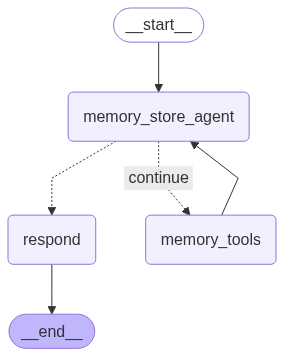

In [15]:
memory_store_agent

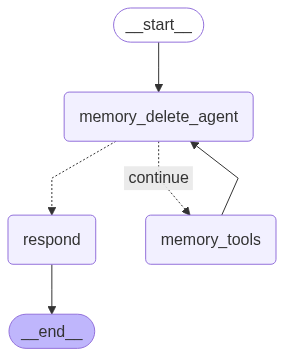

In [16]:
memory_delete_agent

In [17]:

prompt_blueprint = resource_manager.prompt_loader("central_memory_supervisor")

prompt_template = PromptTemplate.from_template(prompt_blueprint)
prompt = prompt_template.invoke({"ToolMessage": '{"tool":"forwarded_response","args":{"from_agent":"news_agent"}}'}).to_string()

print(prompt)

You are the central memory supervisor overseeing two specialized agents:
- Memory Store Agent: Agent that focuses on storing memory requested by user
- Memory Delete Agent: Agent that focuses on deleting memory requested by user

<Agent Instructions>
1. Classify the user query:
   - If it’s about Storing Memory, Deleting Memory or Updating Memory
   - If it’s  asking to remember or store a memory (Permanent Memories or Reminders), invoke Memory Store Agent.
   - If its asking to delete a memory, invoke Memory Delete Agent.
   - If its asking to updated memory by first using Memory Delete Agent to delete relevant existing memory and then using Memory Store Agent to store the new memory.
   examples : Update name from abc to xyz - Memory Delete to delete name stored ABC and then Memory Store Agent to store name XYZ.

2. Delegation protocol**:
   - Use `transfer_to_<agent_name>` tool to pass control.
   - Wait for each agent’s response before deciding if further routing is required.

<Rou

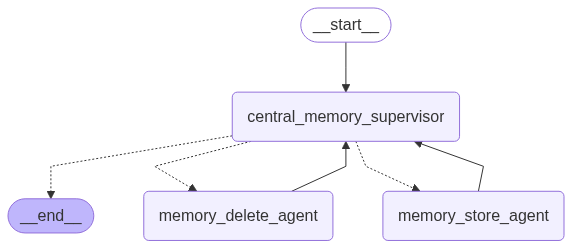

In [13]:
forwarding_tool = create_forward_message_tool("forwarded_response")

graph = create_supervisor([memory_store_agent, memory_delete_agent], 
                        model=conf.model, 
                        supervisor_name='central_memory_supervisor',
                        prompt=prompt,
                        output_mode='last_message')
cms = graph.compile(checkpointer=InMemorySaver())
cms


In [6]:
resource_manager.stream_agent(cms.stream(
    {"messages": [{"role": "user", "content":  "Remember my name is Siddharth"}]},
    conf.ryo_configs, stream_mode="values")
)

================================ Human Message =================================

Remember my name is Siddharth
================================= Tool Message =================================
Name: transfer_to_memory_store_agent

Successfully transferred to memory_store_agent
================================= Tool Message =================================
Name: transfer_back_to_central_memory_supervisor

Successfully transferred back to central_memory_supervisor
================================== Ai Message ==================================
Name: central_memory_supervisor

Your name "Siddharth" has been stored successfully. If there's anything else you'd like me to remember or do, just let me know!


[HumanMessage(content='Remember my name is Siddharth', additional_kwargs={}, response_metadata={}, id='783dafe2-9248-4db3-b0cd-0fe3adcc9a99'),
 ToolMessage(content='Successfully transferred to memory_store_agent', name='transfer_to_memory_store_agent', id='87a1ea6e-c2d5-4533-bb50-58cb66fb57f7', tool_call_id='call_iSeUcZJn8mF6MJx3m6a89uLy'),
 ToolMessage(content='Successfully transferred back to central_memory_supervisor', name='transfer_back_to_central_memory_supervisor', id='c71b89be-c8d2-4e49-97b2-931af7dd2eda', tool_call_id='1fdb673c-01ad-4651-a571-52a36db69c80'),
 AIMessage(content='Your name "Siddharth" has been stored successfully. If there\'s anything else you\'d like me to remember or do, just let me know!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 416, 'total_tokens': 447, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens':

In [7]:
resource_manager.stream_agent(cms.stream(
    {"messages": [{"role": "user", "content":  "Update my name to Rahul"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

Update my name to Rahul
================================= Tool Message =================================
Name: transfer_to_memory_delete_agent

Successfully transferred to memory_delete_agent
content='' additional_kwargs={'tool_calls': [{'id': 'call_20yfEh7vI2HKSAbfzihgTZto', 'function': {'arguments': '{"index_title": "Permanent: User\'s Name"}', 'name': 'extract_index_title_of_the_specific_memory'}, 'type': 'function'}, {'id': 'call_WMVuc3Erox9dFj0RAwRmpco4', 'function': {'arguments': '{"context": "Remember my name is Siddharth"}', 'name': 'extract_specific_memory_from_all_memories'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 507, 'total_tokens': 572, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0,

/Users/siddharth/Desktop/Data-Science-Universe/Projects/LLMS/Ryo/notebooks/../agents/memory_store_agent.py:252: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  central_memory = pd.concat([central_memory, pd.DataFrame(response.model_dump(), index=[0])], ignore_index=True)


================================= Tool Message =================================
Name: transfer_back_to_central_memory_supervisor

Successfully transferred back to central_memory_supervisor
================================== Ai Message ==================================
Name: central_memory_supervisor

Your name has been updated to Rahul in my memory. Let me know if there's anything else I can assist you with!


[HumanMessage(content='Update my name to Rahul', additional_kwargs={}, response_metadata={}, id='0a3bf9f4-4a06-481a-8a07-e47fb5a0d3a9'),
 ToolMessage(content='Successfully transferred to memory_delete_agent', name='transfer_to_memory_delete_agent', id='a0d23f6f-22cc-46c7-9095-e656fc93b5ca', tool_call_id='call_PiwTJfVCVo3aZIZgw3u3KI7M'),
 ToolMessage(content='Successfully transferred back to central_memory_supervisor', name='transfer_back_to_central_memory_supervisor', id='644ea6cf-d22b-42a5-9e85-ab97e6b46bcf', tool_call_id='d25ea4ba-42f1-4025-97b0-cd9e685ee690'),
 ToolMessage(content='Successfully transferred to memory_store_agent', name='transfer_to_memory_store_agent', id='b87f29a8-8727-457a-a2aa-2e3c36a68346', tool_call_id='call_Z8jV48PIhXk17ug9WmxS2E3V'),
 ToolMessage(content='Successfully transferred back to central_memory_supervisor', name='transfer_back_to_central_memory_supervisor', id='8134c01c-66c7-4505-ad2c-bc1c4bcf6f50', tool_call_id='18af5e20-0bdb-48ee-b4d9-bc2f1cf7e2dc'),

In [8]:
resource_manager.stream_agent(cms.stream(
    {"messages": [{"role": "user", "content":  "Forget My Name"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

Forget My Name
================================= Tool Message =================================
Name: transfer_to_memory_delete_agent

Successfully transferred to memory_delete_agent
content='' additional_kwargs={'tool_calls': [{'id': 'call_kA2dZ5H0R2ap3rxrDFAu4cmt', 'function': {'arguments': '{"context": "Forget My Name"}', 'name': 'extract_specific_memory_from_all_memories'}, 'type': 'function'}, {'id': 'call_bN2LFCboui3UyKeZam7HzGQl', 'function': {'arguments': '{"index_title": "Permanent: Permanent: User\'s Name"}', 'name': 'extract_index_title_of_the_specific_memory'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 975, 'total_tokens': 1038, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tok

[HumanMessage(content='Forget My Name', additional_kwargs={}, response_metadata={}, id='702ec437-486b-4583-86c8-a0f4c09b35cb'),
 ToolMessage(content='Successfully transferred to memory_delete_agent', name='transfer_to_memory_delete_agent', id='049e11dd-7080-493a-9d31-c3da99e6b143', tool_call_id='call_E9ipxsZ95fAtPSxP3KQjhe4F'),
 ToolMessage(content='Successfully transferred back to central_memory_supervisor', name='transfer_back_to_central_memory_supervisor', id='084157d8-f84c-41f5-aba2-957fdcbfeae5', tool_call_id='a0776aad-7119-48e6-b9ac-12b28787291d'),
 AIMessage(content="I've successfully erased your name from memory. If you need anything else, just let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 1257, 'total_tokens': 1277, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0